#### *Bangladesh Bank notes recognition*

#### *Dataset Link* : https://www.kaggle.com/datasets/nsojib/bangla-money

In [1]:
# Keras Modules
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,Activation,Conv2D,Dropout,Flatten,MaxPooling2D,BatchNormalization
from keras.preprocessing import image
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16
from keras.models import Model,load_model,Sequential
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import regularizers,Input
from keras.utils import plot_model

In [2]:
# Non-Keras Modules
import os
from imageio.v2 import imread
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random

In [3]:
# print("Num of gpu:", len(tf.config.experimental.list_physical_devices('GPU')))

In [4]:
# Store image dataset in the directory
train_data_dir = '../data/bangladeshi_banknote/Training'
classes = ['1', '2', '5', '10', '20', '50', '100','500','1000']

In [5]:
datagen = image.ImageDataGenerator(
    #rescale = 1.0/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.3
)

In [6]:
# Create the ImageDataGenerator for training dataset

train_generator = datagen.flow_from_directory(train_data_dir
                                                           , target_size=(224, 224)
                                                           , batch_size=10
                                                           , classes=classes
                                                           , seed=0
                                                           , shuffle=True
                                                           , subset='training')

Found 1152 images belonging to 9 classes.


In [7]:
# Create the ImageDataGenerator for validation dataset

valid_generator = datagen.flow_from_directory(train_data_dir
                                                           , target_size=(224, 224)
                                                           , batch_size=5
                                                           , classes=classes
                                                           , seed=0
                                                           , shuffle=True
                                                           , subset='validation')

Found 485 images belonging to 9 classes.


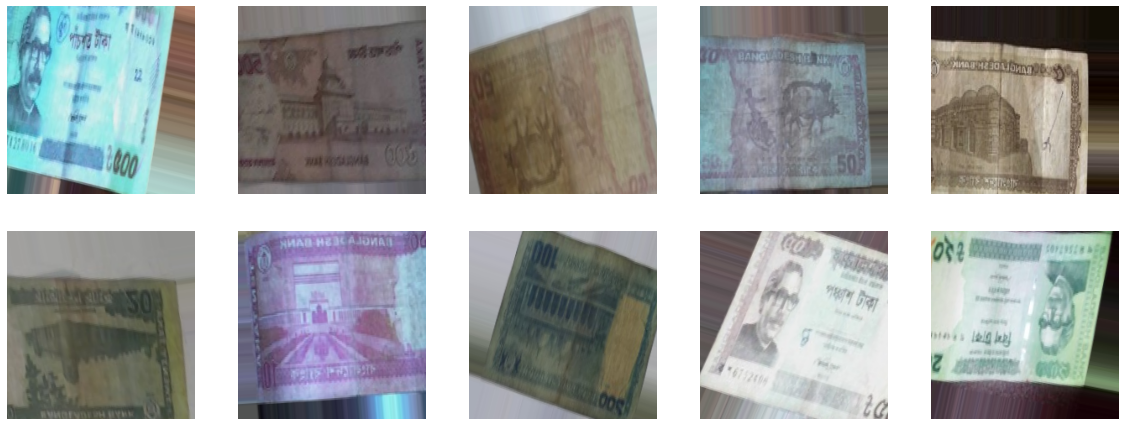

In [8]:
# plotting to understand the training dataset as the images are augmented.
plt.figure(1, figsize=(20, 20))
plt.axis('off')
n = 0
for first_batch in range(train_generator.batch_size):
    n += 1
    image = train_generator.next()[0][first_batch].astype(np.uint8)
    plt.subplot(5, 5, n)
    plt.imshow(image)
    plt.axis('off')
plt.show()

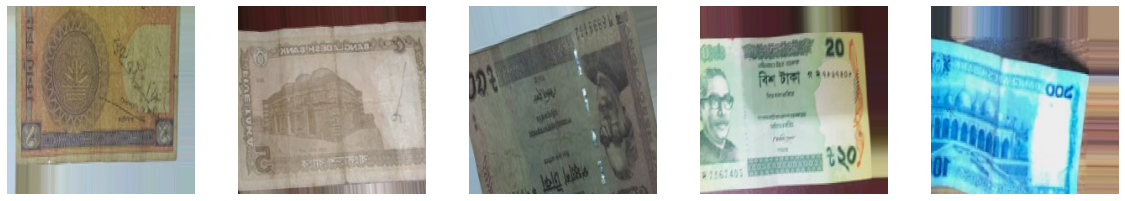

In [9]:
# plotting to understand the validation dataset as the images are augmented.
plt.figure(1, figsize=(20, 20))
plt.axis('off')
n = 0
for first_batch in range(valid_generator.batch_size):
    n +=1
    image = valid_generator.next()[0][first_batch].astype(np.uint8)
    plt.subplot(5, 5, n)
    plt.imshow(image)
    plt.axis('off')
plt.show()

#### *Creating my own model* 

In [10]:
def build_model():

    input_image = Input((224,224,3))
    conv_net1 = Conv2D(16,(3,3),activation='relu',padding='same')(input_image)
    max_pool1 = MaxPooling2D((2,2),padding = 'same')(conv_net1)

    conv_net2 = Conv2D(32,(3,3),activation='relu')(max_pool1)
    max_pool2 = MaxPooling2D((2,2),padding = 'same')(conv_net2)

    conv_net3 = Conv2D(64,(3,3),activation='relu')(max_pool2)
    max_pool3 = MaxPooling2D((2,2),padding = 'same')(conv_net3)
    
    conv_net4 = Conv2D(64,(3,3),activation='relu')(max_pool3)
    max_pool4 = MaxPooling2D((2,2),padding = 'same')(conv_net4)

    batch_norm = BatchNormalization()(max_pool4)
    flatten = Flatten()(batch_norm)

    outputs = []

    dense_1 = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.001))(flatten)
    #dropout_1 = Dropout(0.5)(dense_1)
    
    dense_out = Dense(len(classes),activation='softmax')(dense_1)
    outputs.append(dense_out)

    model_own = Model(input_image,outputs)
    model_own.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

    return model_own

In [11]:
model_own = build_model()
model_own.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 64)        18496 

In [44]:
#plot_model(model_own,to_file='../model_images/bank_note_own_model.png',show_shapes=True,show_layer_names=True,expand_nested=True)

In [13]:
#fit the model
n_epoches_own = 100
steps_own = train_generator.n//train_generator.batch_size
model_own_checkpoint = ModelCheckpoint('../models/own_model_keras.h5',verbose=1, save_best_only=True)
model_own.fit(train_generator, validation_data = valid_generator, steps_per_epoch=steps_own, epochs = n_epoches_own, callbacks=[model_own_checkpoint])

Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 4.4674 - accuracy: 0.2364
Epoch 1: val_loss improved from inf to 21.04312, saving model to ../models\own_model_keras.h5
115/115 [==============================] - 27s 134ms/step - loss: 4.4674 - accuracy: 0.2364 - val_loss: 21.0431 - val_accuracy: 0.1278
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 2.6217 - accuracy: 0.3704
Epoch 2: val_loss improved from 21.04312 to 11.71895, saving model to ../models\own_model_keras.h5
115/115 [==============================] - 13s 113ms/step - loss: 2.6217 - accuracy: 0.3704 - val_loss: 11.7190 - val_accuracy: 0.1732
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 2.5827 - accuracy: 0.3713
Epoch 3: val_loss improved from 11.71895 to 6.18191, saving model to ../models\own_model_keras.h5
115/115 [==============================] - 13s 109ms/step - loss: 2.5827 - accuracy: 0.3713 - val_loss: 6.1819 - val_accuracy: 0.3134
Epoch 4/100
11

In [14]:
# Get the training history
history = model_own.history.history

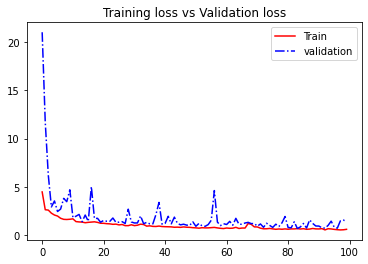

In [15]:
#Plot the loss for both training and validation
plt.title('Training loss vs Validation loss')
plt.plot(history['loss'], label='Train', color='red')
plt.plot(history['val_loss'], label='validation', color='blue', linestyle = "dashdot")
plt.legend()
plt.show()

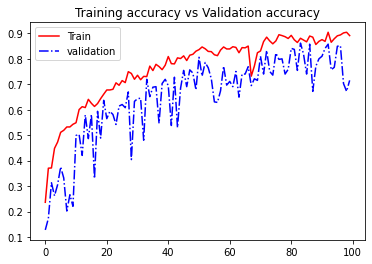

In [16]:
#Plot the accuracy for both training and validation
plt.title('Training accuracy vs Validation accuracy')
plt.plot(history['accuracy'], label='Train', color='red')
plt.plot(history['val_accuracy'], label='validation', color='blue', linestyle = "dashdot")
plt.legend()
plt.show()

#### *Testing accuracy on validation dataset*

In [17]:

test_valid_generator = datagen.flow_from_directory(train_data_dir
                                                           , target_size=(224, 224)
                                                           , batch_size=5
                                                           , classes=classes
                                                           , seed=0
                                                           , shuffle=False
                                                           , subset='validation')

Found 485 images belonging to 9 classes.


In [18]:
pred_own = model_own.predict(test_valid_generator, verbose=0)

# prediction = np.asarray(pred)
prediction_own = np.argmax(pred_own,axis=1)
print(prediction_own)


[1 1 0 2 1 0 2 7 1 0 0 0 1 1 0 4 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 4 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 1 1 6 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 5 1 5 5 2 2 1 1 5 2 1 2 1 2 5 1 5 5
 1 2 2 5 1 2 1 2 5 1 1 5 2 2 5 4 5 2 2 5 2 2 2 2 5 2 5 5 2 2 8 2 2 5 2 5 2
 2 2 5 8 4 1 2 2 1 4 3 1 3 1 3 3 3 5 5 3 3 1 3 3 0 3 3 3 3 3 5 3 3 3 5 3 3
 3 3 3 1 5 3 3 3 2 5 3 3 5 5 5 3 5 3 3 1 3 3 3 3 3 3 3 1 3 4 3 3 5 3 4 4 4
 2 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 7 4 1 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4
 4 4 4 2 2 4 4 4 4 4 4 1 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 6 2 2 2 2 1 5 5 7 5 5 5 5 5 2 2 5 1 5 5 1 5 5 5 5 5 2 5 2
 1 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 4 6 6 6 6 1 6 7
 1 6 6 6 6 6 6 6 4 4 6 6 6 6 6 1 6 1 6 1 6 6 4 6 6 7 7 7 4 2 7 1 7 5 3 7 5
 5 7 7 7 7 7 2 4 4 7 1 7 7 1 7 4 2 7 2 2 2 8 5 6 7 7 2 1 8 6 8 8 8 8 8 8 8
 8 5 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 5 8 8 8 8 8 8 8 5 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8]


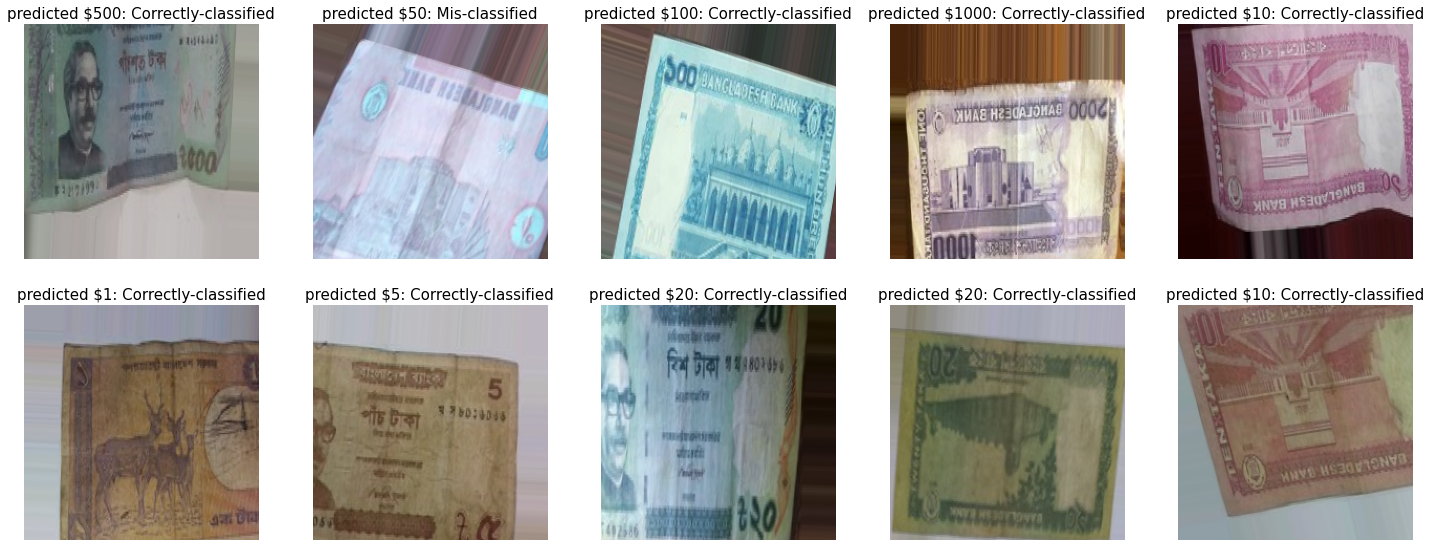

In [19]:
# Plot five random images and their predictions
random.seed(0)
numbers = [random.randint(0, 484) for i in range(0, 10)]
actual_data = test_valid_generator.classes

n = 0

for num in numbers:
   
    for key, value in train_generator.class_indices.items():
        if value == prediction_own[num]:
            key_value = key
    
    n += 1

    image = test_valid_generator[num // 5][0][num % 5].astype(np.uint8)
    

    if prediction_own[num] == actual_data[num] :
        plt.figure(1, figsize=(25, 25))
        plt.subplot(5, 5, n)
        plt.axis('off')
        plt.title(f'predicted ${format(key_value)}: Correctly-classified', fontsize=15)
        plt.imshow(image)
        
    else:
        plt.figure(1, figsize=(25, 25))
        plt.subplot(5, 5, n)
        plt.axis('off')
        plt.title(f'predicted ${format(key_value)}: Mis-classified', fontsize=15)
        plt.imshow(image)


plt.show() 

#### *Training with pretrained models*

In [20]:
#Load the pre-trained model ResNet50
base = ResNet50(weights='imagenet')

In [21]:
# Set parameters in pre-train model to False
for layer in base.layers:
    layer.trainable = False

In [22]:
# Replace the old classification layer with the new classification layer
def model_resnet50():
    last_sec_layers = base.layers[-2].output
    flatten = keras.layers.Flatten()(last_sec_layers)
    connected_model = Dense(len(classes),activation='softmax')(flatten)
    base_input = base.input

    model_resnet50 = Model(inputs = base_input,outputs = connected_model)

    #Use model.compile() to set the configuration'
    model_resnet50.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

    return model_resnet50

In [23]:
# Print the model 
model_resnet50 = model_resnet50()
model_resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [43]:
# plot_model(model_resnet50,to_file='../model_images/bank_note_resnet_model.png',show_shapes=True,show_layer_names=True,expand_nested=True)

In [25]:
# Train the model
EPOCHS = 100
STEPS = train_generator.n // train_generator.batch_size
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
model_checkpoint = ModelCheckpoint('../models/resnet50_keras.h5',verbose=1, save_best_only=True)
model_resnet50.fit(train_generator,validation_data=valid_generator,steps_per_epoch=STEPS,epochs=EPOCHS,callbacks=[early_stopping,model_checkpoint])

Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 1.4299 - accuracy: 0.5254
Epoch 1: val_loss improved from inf to 1.01671, saving model to ../models\resnet50_keras.h5
115/115 [==============================] - 17s 121ms/step - loss: 1.4299 - accuracy: 0.5254 - val_loss: 1.0167 - val_accuracy: 0.6866
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.6722 - accuracy: 0.8126
Epoch 2: val_loss improved from 1.01671 to 0.73158, saving model to ../models\resnet50_keras.h5
115/115 [==============================] - 13s 109ms/step - loss: 0.6722 - accuracy: 0.8126 - val_loss: 0.7316 - val_accuracy: 0.7938
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 0.4934 - accuracy: 0.8695
Epoch 3: val_loss improved from 0.73158 to 0.57026, saving model to ../models\resnet50_keras.h5
115/115 [==============================] - 13s 111ms/step - loss: 0.4934 - accuracy: 0.8695 - val_loss: 0.5703 - val_accuracy: 0.8289
Epoch 4/100
115/115 [==

In [26]:
# Get the training history
history = model_resnet50.history.history

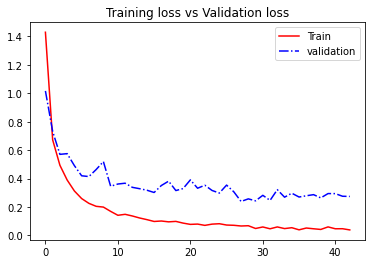

In [27]:
# Plot the loss for both training and validation
plt.title('Training loss vs Validation loss')
plt.plot(history['loss'], label='Train', color='red')
plt.plot(history['val_loss'], label='validation', color='blue', linestyle = "dashdot")
plt.legend()
plt.show()

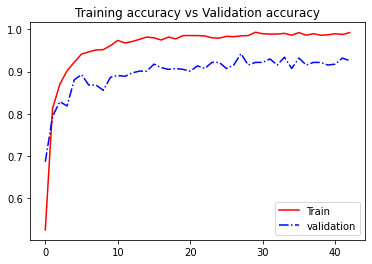

In [28]:
# Plot the accuracy for both training and validation
plt.title('Training accuracy vs Validation accuracy')
plt.plot(history['accuracy'], label='Train', color='red')
plt.plot(history['val_accuracy'], label='validation', color='blue', linestyle = "dashdot")
plt.legend()
plt.show()

In [29]:
pred_resnet50 = model_resnet50.predict(test_valid_generator, verbose=0)

# prediction = np.asarray(pred)
prediction_resnet50 = np.argmax(pred_resnet50,axis=1)
print(prediction_resnet50)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 5 5 2 2 3 2 3 2 5 5 2 5
 2 2 2 2 2 2 2 2 1 5 2 5 5 1 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 5 3 3 3 3 4 3 3 3 4 3 3 3 3 3 5 3 3 3 3 3 3 3 3 3 1 3 3 3 3 4 4 4
 4 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 6 6 6 6 6 6 6 8 6 6 6 6 5 6 6 6 6 6 7 5 5 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 2 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 3
 8 8 8 8]


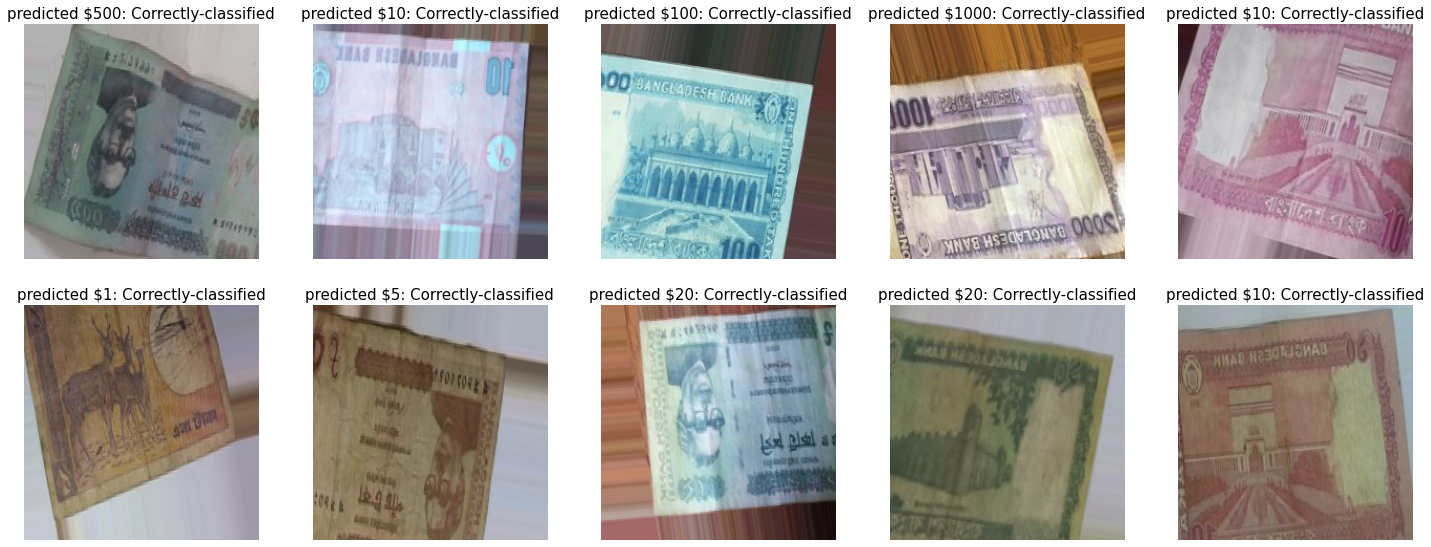

In [30]:
# Plot five random images and their predictions
random.seed(0)
numbers = [random.randint(0, 484) for i in range(0, 10)]
actual_data = test_valid_generator.classes

n = 0

for num in numbers:
   
    for key, value in train_generator.class_indices.items():
        if value == prediction_resnet50[num]:
            key_value = key
    
    n += 1

    image = test_valid_generator[num // 5][0][num % 5].astype(np.uint8)
    

    if prediction_resnet50[num] == actual_data[num] :
        plt.figure(1, figsize=(25, 25))
        plt.subplot(5, 5, n)
        plt.axis('off')
        plt.title(f'predicted ${format(key_value)}: Correctly-classified', fontsize=15)
        plt.imshow(image)
        
    else:
        plt.figure(1, figsize=(25, 25))
        plt.subplot(5, 5, n)
        plt.axis('off')
        plt.title(f'predicted ${format(key_value)}: Mis-classified', fontsize=15)
        plt.imshow(image)


plt.show()

#### *Use the second model VGG16 to do the prediction*

In [31]:
# Use VGG16 to train the model and print out the last validation accuracy.
base_vgg = VGG16 (weights ='imagenet')

In [32]:
for layer in base_vgg.layers:
    layer.trainable = False

In [33]:
def model_vgg():
    second_last_layers = base_vgg.layers[-2].output
    flatten_vgg = keras.layers.Flatten()(second_last_layers)
    connected__vgg_model = Dense(len(classes),activation='softmax')(flatten_vgg)
    base_input_vgg = base_vgg.input

    model_vgg = Model(inputs = base_input_vgg,outputs = connected__vgg_model)

    model_vgg.compile(optimizer ='Adam', loss ='categorical_crossentropy', metrics =['accuracy'])

    return model_vgg

In [34]:
model_vgg = model_vgg()
model_vgg.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [42]:
# plot_model(model_vgg,to_file='../model_images/bank_note_vgg_model.png',show_shapes=True,show_layer_names=True,expand_nested=True)

In [36]:
n_epoches_vgg = 100
steps_vgg = train_generator.n//train_generator.batch_size
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
model_vgg_checkpoint = ModelCheckpoint('../models/vgg16_keras.h5',verbose=1, save_best_only=True)
model_vgg.fit(train_generator, validation_data = valid_generator, steps_per_epoch=steps_vgg, epochs = n_epoches_vgg, callbacks=[early_stopping,model_vgg_checkpoint])

Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 1.4805 - accuracy: 0.5245
Epoch 1: val_loss improved from inf to 1.04334, saving model to ../models\vgg16_keras.h5
115/115 [==============================] - 18s 139ms/step - loss: 1.4805 - accuracy: 0.5245 - val_loss: 1.0433 - val_accuracy: 0.6206
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.7865 - accuracy: 0.7373
Epoch 2: val_loss improved from 1.04334 to 0.81398, saving model to ../models\vgg16_keras.h5
115/115 [==============================] - 15s 130ms/step - loss: 0.7865 - accuracy: 0.7373 - val_loss: 0.8140 - val_accuracy: 0.7278
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 0.6690 - accuracy: 0.7741
Epoch 3: val_loss improved from 0.81398 to 0.73776, saving model to ../models\vgg16_keras.h5
115/115 [==============================] - 17s 143ms/step - loss: 0.6690 - accuracy: 0.7741 - val_loss: 0.7378 - val_accuracy: 0.7546
Epoch 4/100
115/115 [===========

In [37]:
# Get the training history
history = model_vgg.history.history

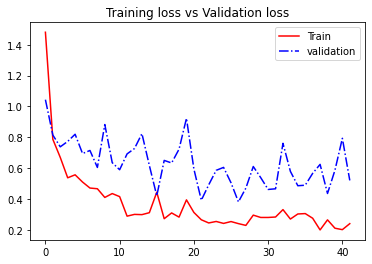

In [38]:
# Plot the loss for both training and validation
plt.title('Training loss vs Validation loss')
plt.plot(history['loss'], label='Train', color='red')
plt.plot(history['val_loss'], label='validation', color='blue', linestyle = "dashdot")
plt.legend()
plt.show()

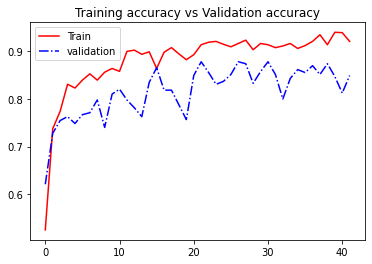

In [39]:
# Plot the accuracy for both training and validation
plt.title('Training accuracy vs Validation accuracy')
plt.plot(history['accuracy'], label='Train', color='red')
plt.plot(history['val_accuracy'], label='validation', color='blue', linestyle = "dashdot")
plt.legend()
plt.show()

In [40]:
pred_vgg = model_vgg.predict(test_valid_generator, verbose=0)

# prediction = np.asarray(pred)
prediction_vgg = np.argmax(pred_vgg,axis=1)
print(prediction_vgg)


[0 0 0 1 0 0 3 0 0 0 3 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 1 2 2 2 2 1 2 2 2 2 1 2 2 3 2 2 5 4 2
 2 3 2 2 4 2 2 2 2 5 1 5 1 1 2 0 5 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2
 2 2 2 2 2 2 2 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 3 5 3 5 3 0 3 3 5 5 3
 3 3 3 3 5 3 3 4 3 3 1 4 3 3 7 3 5 3 6 1 3 2 3 2 3 3 3 3 1 3 3 3 1 3 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 6 4 4 4 4 4 4 4 5
 4 4 7 4 4 4 4 4 4 4 4 5 5 5 5 5 5 4 3 5 5 5 5 5 5 5 5 5 5 5 1 5 7 2 5 5 5
 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 5 5 5 5 5 1 5 5 5 5 5 5 5 5 5 5 2 5 5
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 6 5 7 7 7 7 5 5 7 7 7
 7 7 7 7 7 7 7 7 6 7 1 7 7 7 4 7 4 4 7 7 7 7 7 7 7 7 7 7 8 5 8 8 8 8 8 8 8
 8 4 8 8 4 8 8 8 8 8 8 6 8 8 5 5 8 8 8 8 8 8 6 7 8 8 8 8 8 7 8 8 8 6 8 8 3
 8 8 8 8]


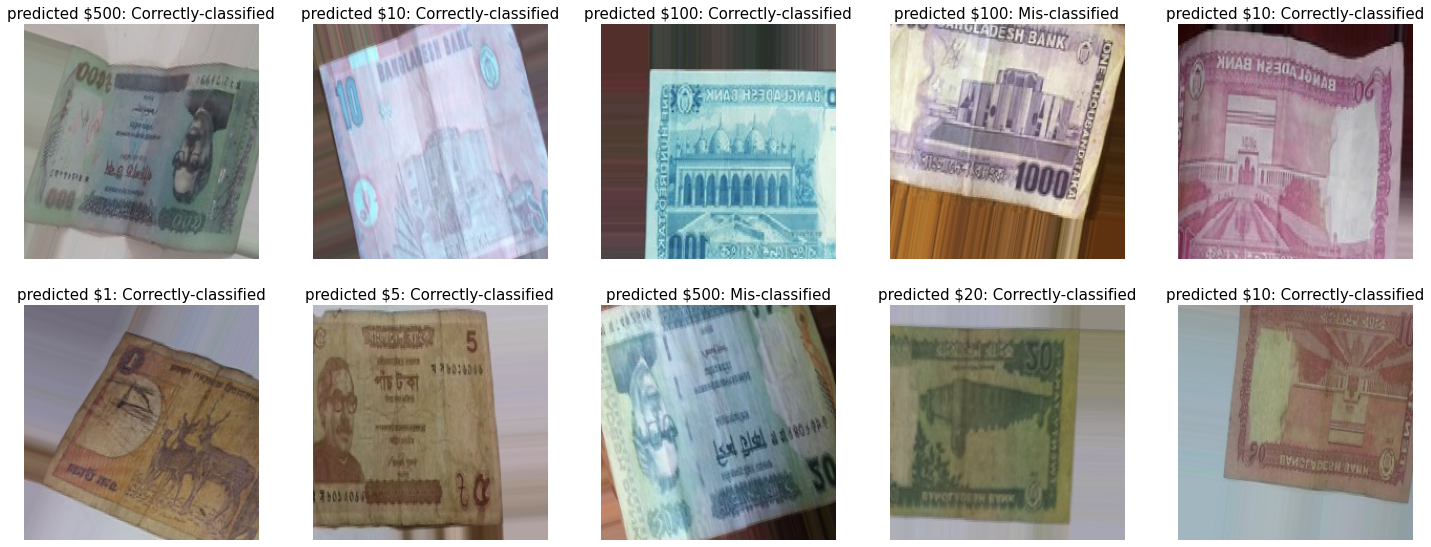

In [41]:
# Plot five random images and their predictions
random.seed(0)
numbers = [random.randint(0, 484) for i in range(0, 10)]
actual_data = test_valid_generator.classes

n = 0

for num in numbers:
   
    for key, value in train_generator.class_indices.items():
        if value == prediction_vgg[num]:
            key_value = key
    
    n += 1

    image = test_valid_generator[num // 5][0][num % 5].astype(np.uint8)
    

    if prediction_vgg[num] == actual_data[num] :
        plt.figure(1, figsize=(25, 25))
        plt.subplot(5, 5, n)
        plt.axis('off')
        plt.title(f'predicted ${format(key_value)}: Correctly-classified', fontsize=15)
        plt.imshow(image)
        
    else:
        plt.figure(1, figsize=(25, 25))
        plt.subplot(5, 5, n)
        plt.axis('off')
        plt.title(f'predicted ${format(key_value)}: Mis-classified', fontsize=15)
        plt.imshow(image)


plt.show()
    